# Using LGR to compute flow gradients on sparse data
This notebook presents an implementation of Lagrangian gradient regression according to the algorithms outlined in Harms, Brunton, and McKeon (2023).  The demonstration will utilize the double gyre flow with the same settings presented in the article.  However, the code can be functionally applied to other data sets that the user might have.  

The algorithmic portion of this code is in the file `LGR` folder.  `LGR/classes.py` contains useful classes for the calculations.  `LGR/jacobian.py` contains functions useful for computing the Jacobian, including a regression function generator.  `LGR/lgr.py` contains the principal algorithms for this demonstration, including a function to orient the trajectories in time, one to compute gradients, one to calculate various metrics, and one to interpolate to a uniform grid for plotting.  Finally, `LGR/plotting.py` contains utilities for plotting the results.  

A general purpose class for analytical flows is also included in the `Flows` folder.  In this case, the double gyre is used, but other flows could easily be defined to work win the `Flows` framework.  

In [1]:
import numpy as np

from LGR.lgr import *
from LGR.jacobian import *
from LGR.classes import *
from LGR.plotting import *
from Flows.Flows import *

import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

## Setting numerical parameters.
Here all user parameters are defined.  The descriptions are given in the code.  

#### Example 1:  Approximating standard FTLE 
LGR can be used to compute FTLE fields from only the first and last positions in a trajectory.  This is akin to the work done by Raben et al. (2014) and Lekien and Ross (2010), whose reference can be found in the Harms et al. (2023) paper.  

To simulate traditional FTLE computations, set `structured = True`, `n_steps = 1`, `dt = 15` (or whatever time you want to compute over), `kNN = 4`, `reg_type = 'None'`, and `nx_int = n_y`.  Note, however, that the other three fields plotted below are meaningless in this example.  

#### Example 2:  Identifying structures in sparse random data
This example is similar to the figures in section 6 of the Harms et al. (2023) paper.  Here, randomly distributed particles are integrated over some time domain and kernel-weighted regression is used to identify the Jacobians used in LGR.  

In this example, use the settings `structured = False`, `n_steps = 150`, `n_particles = 200`, `dt = 0.1` (`n_steps * dt = T` total observation time), `kNN = 25`, `reg_type = 'radialGaussian'`, and `sigma = 0.15`.

In [2]:
# Basic parameters:
flowname = "Gyre"       # Flow being used
structured = False      # If true, particles on a uniform grid
n_particles = 200       # Number of particles to generate if structured = False
n_y = 100               # number of rows in grid if structured = True
n_steps = 100           # Number of time increments
dt = 0.25               # Duration of a single increment

# Specify which metrics to compute from ["ftle", "lavd", "dra", "vort"]
metrics = ["ftle", "lavd", "dra", "vort"]

# Flow parameters
parameters = {  # These are specified as defaults as well. 
    "A": 0.1,
    "epsilon": 0.1,
    "omega": 2*np.pi/10
}

# Set computational parameters for LGR
t = 15                          # time duration for LCS analysis
kNN = 10                        # Number of nearest neighbors to find for each particle
reg_type = 'radialGaussian'     # 'None' or 'radialGaussian'
sigma = 0.1                     # standard deviation if reg_type is radial_gaussian
lam = 0.000000001               # Regularizer for the regression 
nx_int = 150                    # grid length in x for interpolation (plotting)

## Integrate and plot trajectories
Here trajectories are integrated using the functionality from `Flows.py`.  Results are plotted as a diagnostic, but can be turned off.  

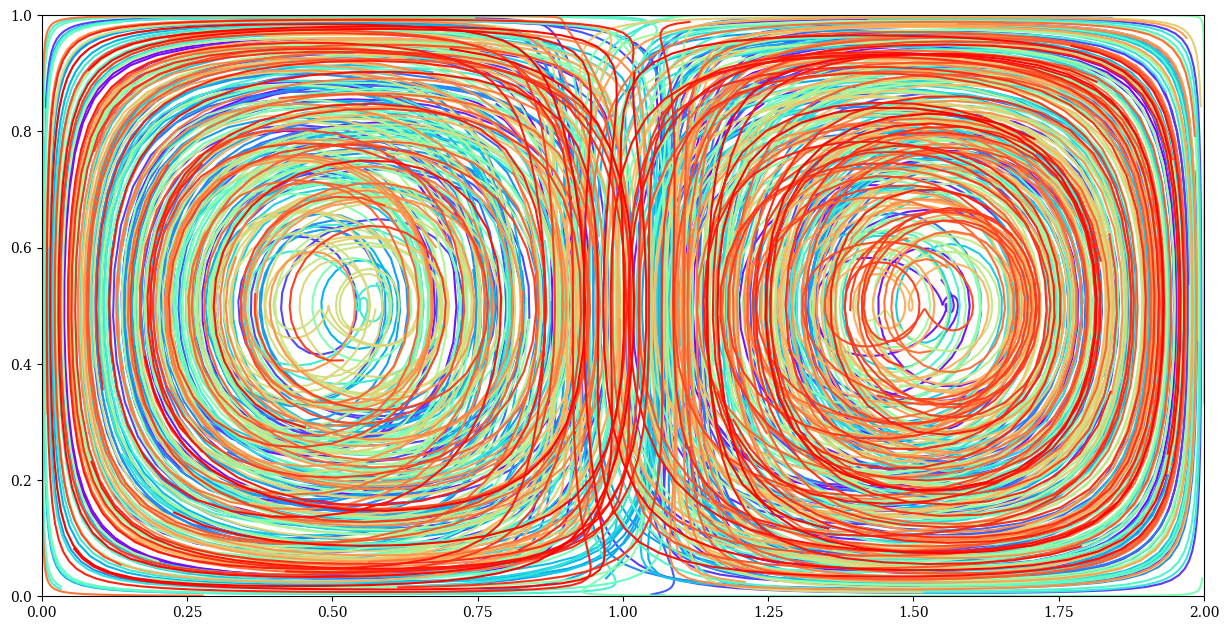

In [3]:
# Initialize the flow 
flow = Flow()

if structured:
    # Make vectors associated with each axis.
    domain = np.array([[0, 2],[0, 1]])
    n_x = 2*n_y         # number of columns
    eps = 0.001        # for visualization
    y_vec = np.linspace(domain[1, 0] + eps, domain[1, 1] - eps, n_y)     # 25 rows
    x_vec = np.linspace(domain[0, 0] + eps, domain[0, 1] - eps, n_x)     # 50 columns
    n_particles = n_x * n_y

    # Then, make the mesh grid and flatten it to get a single vector of positions.  
    mesh = np.meshgrid(x_vec, y_vec)
    x = mesh[0].reshape(-1, 1)
    y = mesh[1].reshape(-1, 1)
    ICs = np.append(x, y, axis=1)

else:
    # Generate random initial conditions on domain [[0,2],[0,1]] -> [x, y]
    ICs = np.random.rand(n_particles,2)
    ICs[:, 0] *= 2

# Generate a time vector
tvec = np.linspace(0, dt*n_steps, n_steps + 1) 

# Generate the trajectories
flow.predefined_function(flowname, ICs, tvec, parameters=parameters)
flow.integrate_trajectories()
trajectories = flow.states

# Generate a list of particles
particleList = []
for i in range(n_particles):
    state = np.squeeze(trajectories[i, :, :])
    particleList.append(SimpleParticle(state, tvec, i))
    
# plot the trajectories
plot_trajectories(trajectories)

## Set the regression function
Here the regression function is generated by a function generator defined in `LGR/jacobian.py`.  

In [4]:
# Generate the regression function
regfun = setRegressionFunction(kernel=reg_type, lam=lam, sig=sigma)

## Orient the data in time and identify neighbors
For the algorithms to be effective, particle-oriented data must be transferred to time-oriented data.  As this is being done, nearest neighbors of each particle are identified. 

In [5]:
# Generate a data frame
df = generateDF(particleList, kNN)
n_particles = len(df['indices'][0])

KNN: t = 0.0
KNN: t = 6.25
KNN: t = 12.5
KNN: t = 18.75
KNN: t = 25.0


## Regress gradients along each trajectory
In this step the flow map jacobian and the velocity gradient are computed using the regression function from above.  

In [6]:
# Perform the regressions
calcJacobianAndVelGrad(df, regfun=regfun)

Regression: t = 0.0
Regression: t = 6.25
Regression: t = 12.5
Regression: t = 18.75


## Compute LCS metrics
With the gradients computed, the specified flow metrics are computed.  

In [7]:
# Compute the metrics on each particle trajectory
computeMetrics(df, t, metric_list=metrics)

Metrics: t = 0.0
Metrics: t = 6.25
Metrics: t = 12.5
Metrics: t = 18.75


## Interpolate to a grid for plotting
At this point, LGR is already done.  However, to plot as a field, the metrics must be interpolated onto a grid.  

Radial basis function (RBF) interpolation is nice, since it fits a function over the entire domain.  However, it does not scale well with many particles.  Therefore, if over 1000 particles are used in the computation, then cubic interpolation is implemented.  

In [8]:
# Interpolate the metrics onto a grid assuming the double gyre flow.
xvec = np.linspace(0, 2, nx_int)
yvec = np.linspace(0, 1, int(nx_int/2))   # square cells on the double gyre flow
gridvectors = [xvec, yvec]
if n_particles < 1000:
    generateFields(df, gridvectors, approach='rbf', method='multiquadric')
    interpstr = 'rbf_mq'
else:
    generateFields(df, gridvectors, approach='interp', method='cubic')
    interpstr = 'int3'

Interpolation: t = 0.0
Interpolation: t = 6.25
Interpolation: t = 12.5
Interpolation: t = 18.75


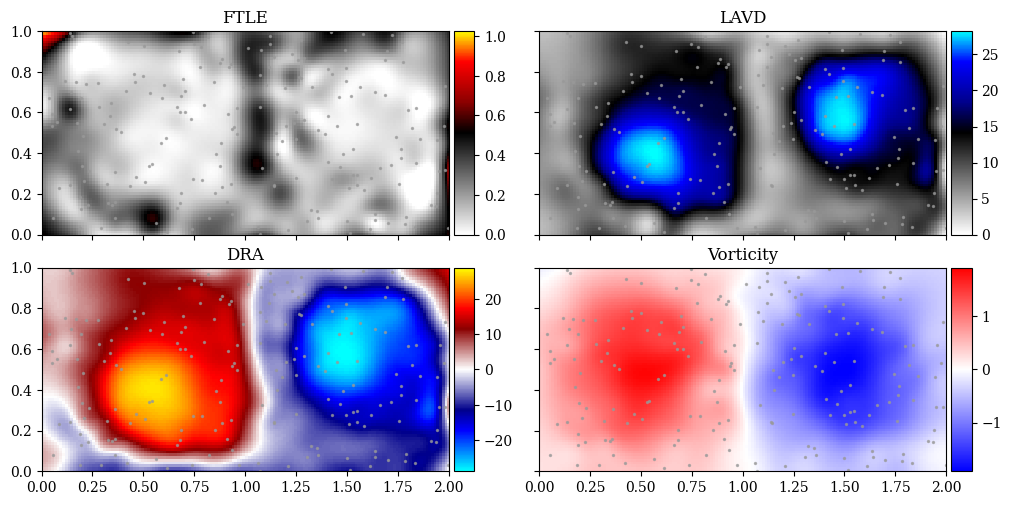

In [9]:
# plot the results
plotAllMetrics(df, xvec, yvec, tstep=0, particles=True)